In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '307002',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/C9U2E51tkzLljewFEGQ74g__thumb/img/4KV3wj3NiJDgGTh3zmW0_8Ph3Zc=/fit-in/200x150/filters:strip_icc()/pic5837347.jpg',
  'name': 'Regicide',
  'yearpublished': '2020'},
 {'id': '337627',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'}]

In [6]:
def get_game_by_id(game_id, field='name'):
    for a in hot_array:
        if a['id'] == str(game_id):
            return a[field]

In [7]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 29)
page number = 20 (max: 100, len: 23)
page number = 30 (max: 100, len: 18)
page number = 40 (max: 100, len: 12)
page number = 50 (max: 100, len: 9)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 5)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 3)
page number = 100 (max: 100, len: 1)
comments_df shape: (124411, 4)


,id,username,rating,value
0,307002,AgentMeat,2,"only solo, played with normal deck of cards, s..."
1,307002,Akuden,8,Kickstarted. Tried out the game solo and at 2 ...
2,307002,amqueue,N/A,kickstarter
3,307002,andrewkapish,N/A,Unplayed
4,307002,Angelo the Magician,9,I only play the solo version and that one is ...
...,...,...,...,...
124406,167791,z_zadar,9,Some games are so much fun. Others can be a li...
124407,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
124408,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
124409,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [8]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [9]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 19591 for 'remove_short_comments' - min len: 25 - method: unrated


In [10]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [11]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9        19953
10       19176
8        17764
7         9324
N/A       8095
         ...  
9.372        1
8.459        1
8.09         1
1.62         1
6.011        1
Name: rating, Length: 608, dtype: int64

In [12]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(96725, 5)

In [13]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(8095, 5)

## CREATE TRAINING AND VALIDATION DATA

In [14]:
# use rated comments (reviews) to train the model

In [15]:
rated_comments = rated_comments.sample(frac=1)

In [16]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [17]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'2020 10x10'

In [18]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'[05/06/2020] Rating: 6 Sin negar que sea un gran juego, hay algo que no me termina de convencer, seguramente es que se me hace algo largo. Las mecánicas están bien combinadas, rutas, gestión de recursos, selección de acciones, deck building y el curioso sistema de puntuación final con las cartas (me gusta ese concepto) pero me resulta seco en general, no diré que no a una partida pero seguramente nunca sea mi opción'

## COMPOSE MODEL

In [19]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [20]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
48/48 - 5s - loss: 0.6402 - accuracy: 0.6264 - val_loss: 0.5160 - val_accuracy: 0.8463
Epoch 2/100
48/48 - 3s - loss: 0.4722 - accuracy: 0.8558 - val_loss: 0.4316 - val_accuracy: 0.8576
Epoch 3/100
48/48 - 3s - loss: 0.3870 - accuracy: 0.8615 - val_loss: 0.3638 - val_accuracy: 0.8638
Epoch 4/100
48/48 - 3s - loss: 0.3188 - accuracy: 0.8794 - val_loss: 0.3265 - val_accuracy: 0.8749
Epoch 5/100
48/48 - 3s - loss: 0.2756 - accuracy: 0.8951 - val_loss: 0.3110 - val_accuracy: 0.8803
Epoch 6/100
48/48 - 3s - loss: 0.2457 - accuracy: 0.9064 - val_loss: 0.3060 - val_accuracy: 0.8807
Epoch 7/100
48/48 - 3s - loss: 0.2232 - accuracy: 0.9152 - val_loss: 0.3076 - val_accuracy: 0.8795
Epoch 8/100
48/48 - 3s - loss: 0.2041 - accuracy: 0.9229 - val_loss: 0.3139 - val_accuracy: 0.8779
Epoch 9/100
48/48 - 3s - loss: 0.1882 - accuracy: 0.9301 - val_loss: 0.3211 - val_accuracy: 0.8736
Epoch 10/100
48/48 - 3s - loss: 0.1739 - accuracy: 0.9365 - val_loss: 0.3324 - val_accuracy: 0.8718
32/32 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002ED0EF8BEB0>,
             param_grid={})

In [21]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [22]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [24]:
epochs = range(1, len(acc) + 1) 

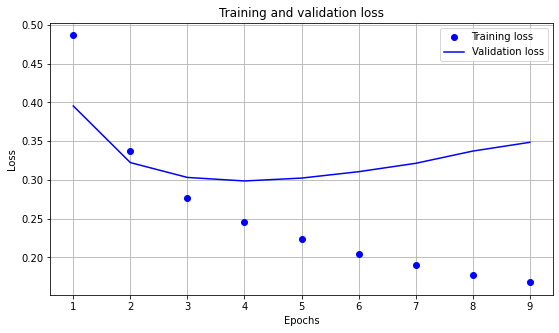

In [25]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

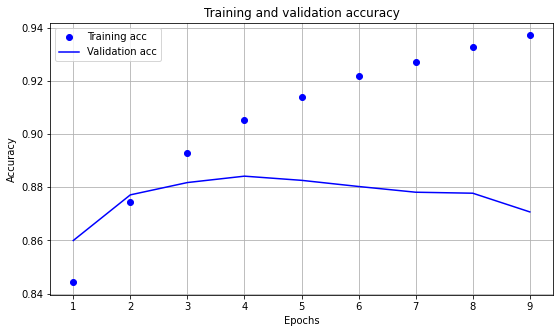

In [26]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [27]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"2020 10x10"
score: 1.000000
actual: 1

input:
"3/3/5/5/5  21/25"
score: 1.000000
actual: 1

input:
"This game has lived up to its reputation with me and my gaming group. I would play it every night if we could get together."
score: 1.000000
actual: 1

input:
"Not bad at all... I usually loathe press your luck games... but this one is so well designed it's hard for me to find fault in it, and in fact I find myself jumping at the chance to play when others offer whereas usually I’d cringe. I enjoyed it far more than I anticipated, and most of my quibbles are matters of personal taste as opposed to objective flaws. I still think the intrinsic vices of Press Your Luck genre games are there... higher chances of rewarding foolish risks and randomly punishing smart plays than is desireable... but a vareity of fairly deep strategic elements along with some catch-up mechanics work to make sure smart play is rewarded while no player falls too desperately behind easily... the bag building

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
## APPLY MODEL ON NON-RATED COMMENTS

In [29]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Boards and map came severely warped."
score: 0.000000

input:
"Aquired April 2019. Traded away March 2020"
score: 1.000000

input:
"Own two copies combined, second set has markers repainted to allow play for 2-8 players"
score: 1.000000

input:
"Gekocht na Kickstarter als pre-order samen met andere Brass-spel voor CAD 155,- // 115 Euro,- incl verzendkosten"
score: 1.000000

input:
"W/ vagabond pack and resin clearing markers"
score: 1.000000

input:
"Egypte & Crète Baléares & Chypre Gaule & Corse Britannia & Germanie Salsa Venus"
score: 1.000000

input:
"Solo autòmata (no-oficial)  50€ - Jupiter Juegos"
score: 1.000000

input:
"First play was kind of meh.  So although it says this game is 10+, it did not go well with a 10 year old.  They didn't seem to understand what cards needed to be played in the tricks to help the group win (they are familiar with trick-taking games BTW).  IMO there is a little too much logical thinking for someone at that intelligence level.  Als

## REGRESSOR

In [30]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002F0613C38E0>,
             param_grid={})

In [31]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [32]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [33]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [34]:
epochs = range(1, len(mean_squared_error) + 1) 

In [35]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.22


In [36]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.06


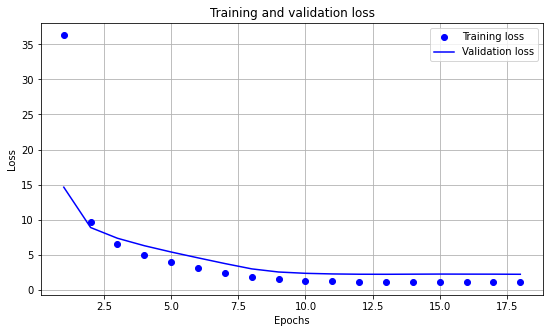

In [37]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

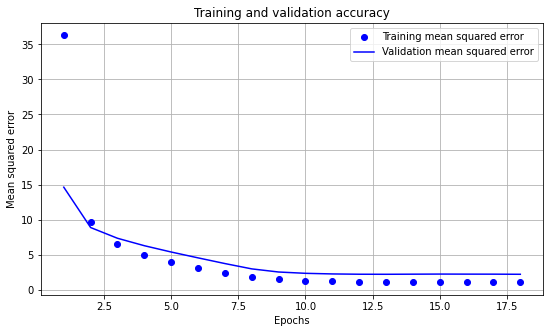

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [39]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"2020 10x10"
score: 8.66
actual: 10.00 

input: 
"3/3/5/5/5  21/25"
score: 9.08
actual: 9.50 

input: 
"This game has lived up to its reputation with me and my gaming group. I would play it every night if we could get together."
score: 9.20
actual: 10.00 

input: 
"Not bad at all... I usually loathe press your luck games... but this one is so well designed it's hard for me to find fault in it, and in fact I find myself jumping at the chance to play when others offer whereas usually I’d cringe. I enjoyed it far more than I anticipated, and most of my quibbles are matters of personal taste as opposed to objective flaws. I still think the intrinsic vices of Press Your Luck genre games are there... higher chances of rewarding foolish risks and randomly punishing smart plays than is desireable... but a vareity of fairly deep strategic elements along with some catch-up mechanics work to make sure smart play is rewarded while no player falls too desperately behind easily... the bag bu

## COMPARE CLASSIFIER VS REGRESSOR

In [40]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"more-or-less perfect condition. $35 CAD OBO. Prefer pickup in Toronto but can ship."
    reg score: 7.05
    clf score: 1

"Complexity: 3.96 # Players: Solo OK, Best is 2"
    reg score: 8.53
    clf score: 1

"Kickstarter Faithful Pledge (Base Game + Tomb of Wonders) Erw. Pantheon (Kickstarter) Erw. Pharaoh (Kickstarter)"
    reg score: 7.37
    clf score: 1

"Pre-Ordered last November. Excruciating wait, but it was fun reading the comments here, and viewing the reviews and playthroughs menwhile. And of course, studying the Gloomhaven Rules in November, December, January, Feb. I am just starting to play the game (Solo) and it has somehow lived up to my expectations. While unboxing and unpacking, I admired all the work that went into laying out all those punch pieces on the many, many pieces of cardboard. The manual is very good, also. While playing, it is remarkably easy to find  important details quickly."
    reg score: 9.54
    clf score: 1

"BGA online version. This plays much be

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [41]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.73 |           1949 |
| 124361 |          8.19 |           3971 |
| 162886 |          8.37 |           3722 |
| 167355 |          8.42 |           2022 |
| 167791 |          8.20 |           8544 |


In [42]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [43]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.37 |            266 |
| 124361 |          8.14 |            258 |
| 162886 |          8.08 |            327 |
| 167355 |          8.39 |            215 |
| 167791 |          8.31 |            455 |


In [44]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [45]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/C9U2E51...","<a href=""https://boardgamegeek.com/boardgame/3...",7.978351,8.387620,8.013720,1,2020
1,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.399296,8.666080,2,2022
2,"<img src=""https://cf.geekdo-images.com/_al0scM...","<a href=""https://boardgamegeek.com/boardgame/2...",7.514186,8.140641,7.674593,3,2021
3,"<img src=""https://cf.geekdo-images.com/cwQZOU3...","<a href=""https://boardgamegeek.com/boardgame/3...",9.333333,9.101252,9.200716,4,2022
4,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.140970,7.155785,7.141696,5,2021


In [46]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [47]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Regicide,7.978351,8.387620,8.013720,1,2020
2,,Voidfall,10.000000,8.399296,8.666080,2,2022
3,,Ankh: Gods of Egypt,7.514186,8.140641,7.674593,3,2021
4,,Black Rose Wars: Rebirth,9.333333,9.101252,9.200716,4,2022
5,,Descent: Legends of the Dark,7.140970,7.155785,7.141696,5,2021


In [48]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.399296,8.666080,2,2022
2,,Black Rose Wars: Rebirth,9.333333,9.101252,9.200716,4,2022
3,,Eclipse: Second Dawn for the Galaxy,8.740193,8.088716,8.643023,43,2020
4,,War of the Ring: Second Edition,8.731068,8.370712,8.687793,40,2012
5,,Brass: Birmingham,8.676736,8.217125,8.636559,21,2018


In [49]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Black Rose Wars: Rebirth,9.333333,9.101252,9.200716,4,2022
2,,War of the Ring: Second Edition,8.731068,8.370712,8.687793,40,2012
3,,Voidfall,10.000000,8.399296,8.666080,2,2022
4,,Eclipse: Second Dawn for the Galaxy,8.740193,8.088716,8.643023,43,2020
5,,Brass: Birmingham,8.676736,8.217125,8.636559,21,2018


In [50]:
# model.save('saved_model\my_model')

In [51]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [52]:
# some examples on "long" comments vs short comments

In [53]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [54]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\" ({get_game_by_id(c['id'])}) \nscore: {c['rating']:.2f}\n"), axis=1);

"The illustrations do look better than TM, but making it even more card focused is the wrong move for me. Worse than that, it is not even a 100% card game as there are the hexes and board." (Terraforming Mars: Ares Expedition) 
score: 3.78

"KS edition, contains the aftermath expansion with Medic and other KS added characters. Definitely available for trade, but it would have to be a worthwhile one." (Nemesis) 
score: 6.52

"WTP 1/4 [AREA CONTROL] 3-4 players; 60-90 minutes; The love child of Midgard and Chaos in the Old World (who was unfortunately born with the defect of card drafting)" (Blood Rage) 
score: 6.76

"2 copies 1 NIS @ ff Open box contains expanded board, Folded Space insert, & realistic resources from Stonemaier Treasure Chest " (Scythe) 
score: 6.93

"Me and my wife have spent a few evenings playing this game, simple to set up and play through a few games to wind the evening down! Solid game! " (7 Wonders Duel) 
score: 7.69

"Alien SemiKooperativ Spieler können sterben,

## RANDOM FOREST - TEST

In [55]:
# no support for Windows at the moment - waiting for it to test